 # PyFD for Marketing Success Prediction
 This third tutorial will again discuss the general functionalities of the `PyFD` package.
 In-depth explanations of the API are left for subsequent tutorials. In this notebook, we will decompose an ExplainableBoostingMachine (EBM)
 trained on the [Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing) datset, which aims at predicting successes of phone calls during 
 a Bank's marketing campaign. Let us see how to interpret the complex model in spite the presence of feature interactions.

 ## Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score
from joblib import dump, load

from pyfd.data import get_data_marketing

/home/gabriel/anaconda3/envs/FDTrees/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 ## Input Features
The Marketing dataset aims to predict the success of a marketing campaign conducted by
a Portuguese banking institution. Each of the 45K instances is phone call and the binary
target $y$ represents whether the subject has accepted ($y = 1$) or refused ($y = 0$) to make a
term deposit. Every single phone call is characterized by 16 features.

We start by loading the data and a `Features` object that stores
information about the various features. Note that the data **X** must **always**
be a numerical numpy array. Categorical features are assumed to have been ordinally encoded.

In [3]:
# `use_target_encoder=True` will ordinally encode categorical variables in terms of average target value
X, y, features = get_data_marketing(use_target_encoder=True)
# We rename some categories to be more compact (optional)
features.feature_objs[6].cats = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
print(X.shape)
print(y[:20])
features.summary()

/home/gabriel/Desktop/POLY/PHD/Research/FunctionalDecomp/PyFD/pyfd/data.py:351: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(months, range(12))


(45211, 16)
[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1]
|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | age                | num_int            | 78         | [0]              |
| 1 | default            | bool               | 2          | [1]              |
| 2 | balance            | num                | inf        | [2]              |
| 3 | housing            | bool               | 2          | [3]              |
| 4 | loan               | bool               | 2          | [4]              |
| 5 | day                | num_int            | 31         | [5]              |
| 6 | month              | ordinal            | 12         | [6]              |
| 7 | duration           | num                | inf        | [7]              |
| 8 | campaign           | num                | inf        | [8]              |
| 9 | pdays              | num                | inf        | [9]  

 This dataset involves 16 features of various types. The following Table can help understand their meaning and domain.

<p align="center">
    <img src="./Images/Features_mark.png" width="600">
</p>

 ## Fitting the model
 Having fetched the data, we fit a `ExplainableBoostingClassifier`.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = ExplainableBoostingClassifier(random_state=0, n_jobs=-1)

**Do not run the following cells if you have already trained the model. Skip to later cells.**

In [ ]:
grid = {"max_bins": [256, 512, 1024],
        'outer_bags' : [10, 15, 20],
        'learning_rate' : [1, 0.1, 0.01],
        'interactions':[1, 2, 3, 4]}
search = RandomizedSearchCV(
    model,
    cv=KFold(),
    scoring='f1',
    param_distributions=grid,
    verbose=2,
    n_iter=20
)
search.fit(X_train, y_train)

In [ ]:
# Recover the optimal CV model
model = search.best_estimator_
res = search.cv_results_
cv_perf = np.nan_to_num(res['mean_test_score'], nan=-1e10)
best_idx = np.argmax(cv_perf)
ebm_score = np.array([res[f"split{i}_test_score"][best_idx] for i in range(5)])
print(ebm_score)

In [ ]:
plt.figure()
plt.scatter(res['param_learning_rate'], cv_perf, c=res['param_max_bins'], alpha=0.75)
plt.colorbar()
plt.plot(res['param_learning_rate'][best_idx], cv_perf[best_idx], 'r*', markersize=10, markeredgecolor='k')
plt.xlabel("Learning Rate")
plt.ylabel("Cross-Validated f1 score")
plt.xscale('log')

In [ ]:
# Save the model for later
dump(model, os.path.join("models", "mark_ebm.joblib"))

**Start from here if you have already trained and dumped the model.**

In [5]:
# Load the model
model = load(os.path.join("models", "mark_ebm.joblib"))
test_preds = model.predict(X_test)
print(f1_score(y_test, test_preds))

0.5216413715570545


## Computing Additive Explanations

Explainable Boosting Machines are advertised as transparent because the model is explicitelly constrained to take the form

$$ h(x) = \text{intercept} + \sum_{i=1}^d g_j(x_j) + \sum_{i<j}g_{ij}(x_i, x_j)$$

where the function $g_j$ only depends on $x_j$ and $g_{ij}$ only depends on $x_i$ and $x_j$. In technical terms, EMBs are constrained to only model
    main effects and pair-wise feature interactions. As a result, if you have enough time, EBMs can be introspected by visualizing each individual function $g_j$ and $g_{ij}$.

So why use `PyFD` to decompose the model if it is already written in a decomposed manner? The reason is that, although EBMs are naturally decomposed, their build-in decomposition 
is not universal across model types. If we decide to change the EBM to a Neural Network with improved performance, we want to extract explanations of the same nature. Moreover, we want the methodologies of computing local/global feature importance, computing regional explanations, and grouping features to be applicable
no matter what model type ends up being selected. 

Since the functional decompositions computed by `PyFD` are model-agnostic, they can be applied to any model,
including EBMs.

In [6]:
from pyfd.decompositions import get_components_ebm
# Compute the Functional Decomposition of the EBM
background = X_train[:2000]
decomposition = get_components_ebm(model, background, background, features, anchored=True)

# The keys are tuples encoding subsets of features
print(decomposition.keys())
# The () key is the intercept
print(decomposition[()].shape)
# The key (0,) is the term h_1(x_1) of the PyFD decomposition
print(decomposition[(0,)].shape)

dict_keys([(), (0,), (1,), (2,), (3,), (4,), (5,), (6,), (5, 6), (7,), (3, 7), (6, 7), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (6, 14), (15,)])
(2000,)
(2000, 2000)


In [7]:
from pyfd.shapley import shap_from_decomposition
# Compute the Shapley Values
shap_values = shap_from_decomposition(decomposition)

Text(0.5, 23.52222222222222, 'Global Feature Importance')

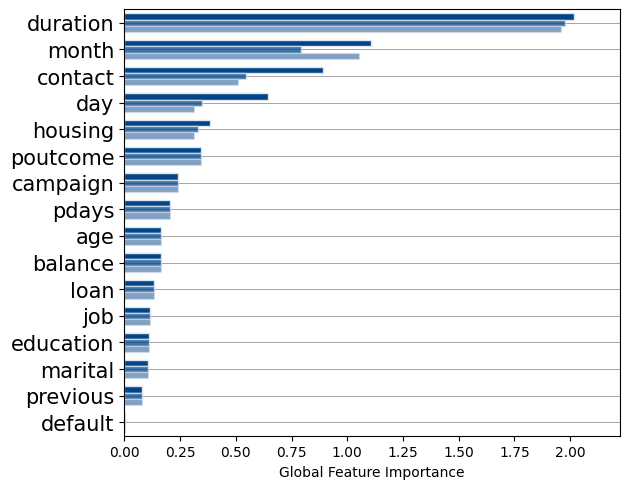

In [8]:
from pyfd.decompositions import get_PDP_PFI_importance
from pyfd.shapley import get_SHAP_importance
from pyfd.plots import bar

I_PDP, I_PFI = get_PDP_PFI_importance(decomposition)
I_SHAP = get_SHAP_importance(shap_values)
bar([I_PFI, I_SHAP, I_PDP], features.names())
plt.xlabel("Global Feature Importance")

This feature importance plots reveals strong disagreements between the PDP/SHAP/PFI importance of `month`, `contact`, and `day`.
These disagreements are caused by feature interactions involving these features, which can be visualized using the
`decomposition_graph` function.

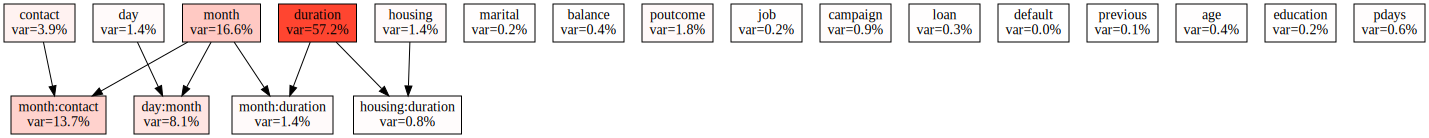

In [9]:
from pyfd.plots import decomposition_graph
dot = decomposition_graph(decomposition, features.names())
dot

Disagreements are also apparent when plotting the main effects (the $h_i$ functions extracted by `PyFD`) and SHAP values, especially for the `month` feature.

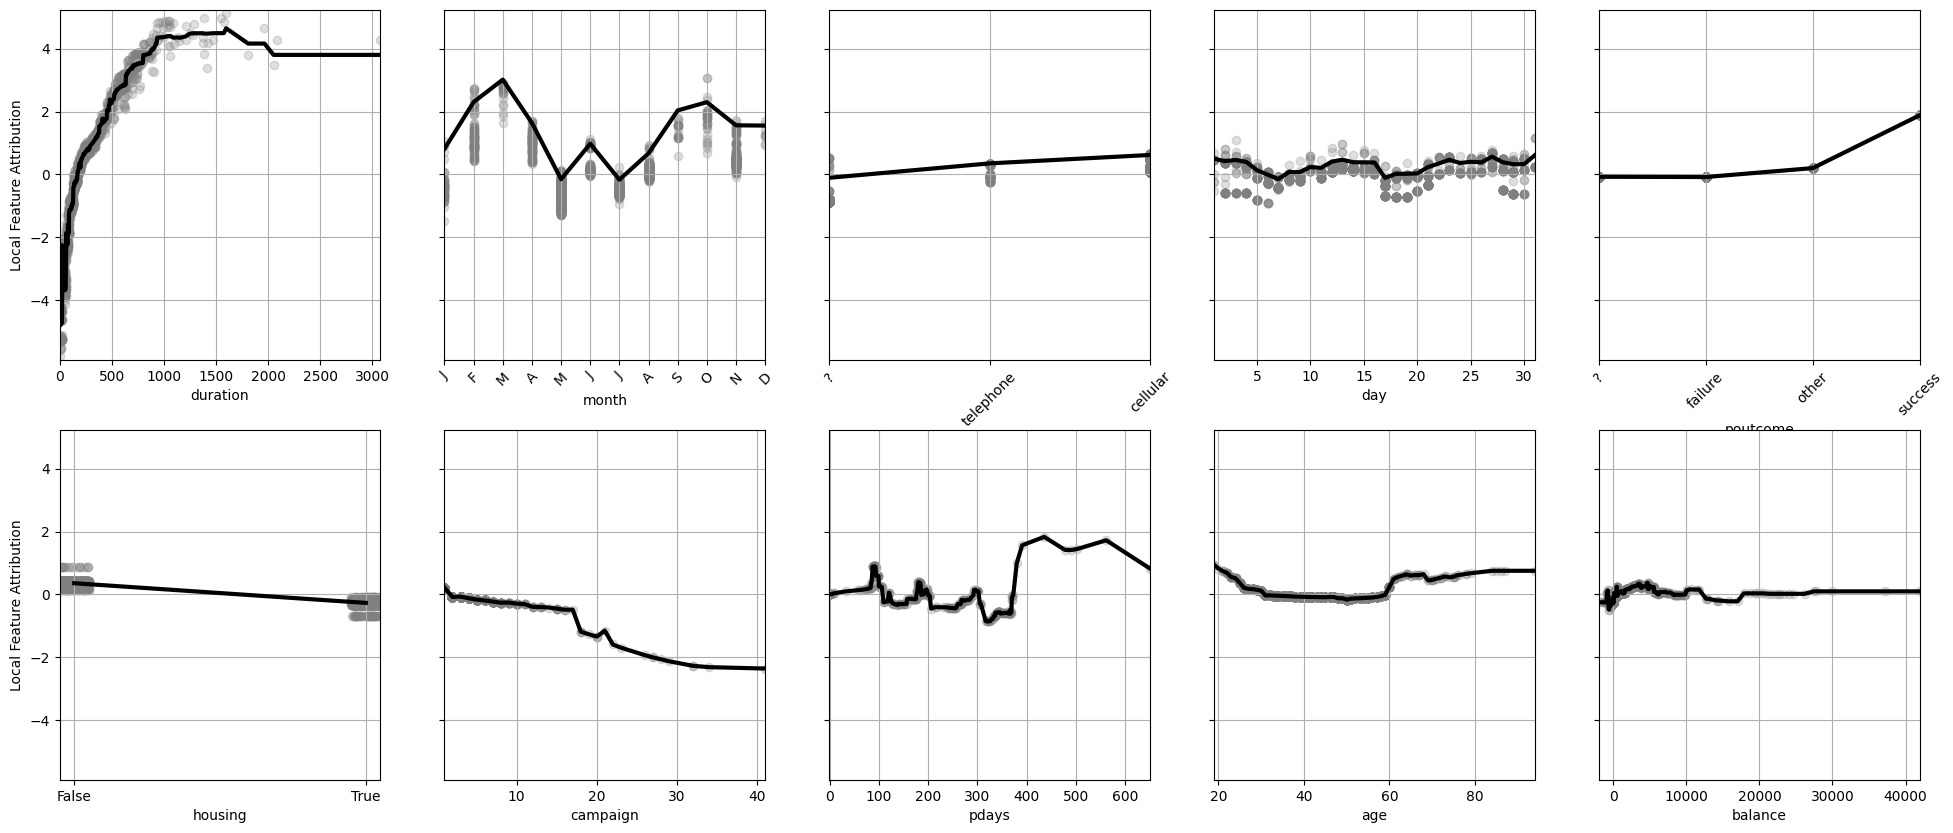

In [11]:
from pyfd.plots import attrib_scatter_plot

attrib_scatter_plot(decomposition, shap_values, background, features, idxs=10, n_cols=5, normalize_y=True, figsize=(24, 10))

Like in previous tutorials, we increase agreement between the post-hoc explanations methods by reducing the strenght of feature interactions, as measured by the `get_CoE` function.

In [12]:
from pyfd.decompositions import get_CoE

print(get_CoE(decomposition))

33.61291994169684


## Increasing Explanations Alignment

### Feature Grouping
By lucky coincidence, the two features `day-month` that interact also happen to share a semantic meaning. They both relate to the concept of
“current date”. As a result, it makes sense to treat them as a grouped feature `day:month`. So, instead of attributing a separate importance to `day=12` and `month=jun`, 
we can provide a single attribution to the date `day=12:month=jun`.

In [13]:
grouped_features = features.group([[5, 6]])
grouped_features.summary()

|Idx|        Name        |        Type        |    Card    |      Groups      |
-------------------------------------------------------------------------------
| 0 | age                | num_int            | 78         | [0]              |
| 1 | default            | bool               | 2          | [1]              |
| 2 | balance            | num                | inf        | [2]              |
| 3 | housing            | bool               | 2          | [3]              |
| 4 | loan               | bool               | 2          | [4]              |
| 5 | duration           | num                | inf        | [7]              |
| 6 | campaign           | num                | inf        | [8]              |
| 7 | pdays              | num                | inf        | [9]              |
| 8 | previous           | num                | inf        | [10]             |
| 9 | job                | ordinal            | 12         | [11]             |
| 10| marital            | ordinal      

In [14]:
# Compute the functional decomposition with grouped features
grouped_decomposition = get_components_ebm(model, background, background, features=grouped_features)
print(get_CoE(grouped_decomposition))

15.454638198494184


Grouping the "date" features are reduced the CoE by half. This is a considerable improvement but there is clearly room for more.
The remaining strong interactions involve the "date" feature and the `contact` one.

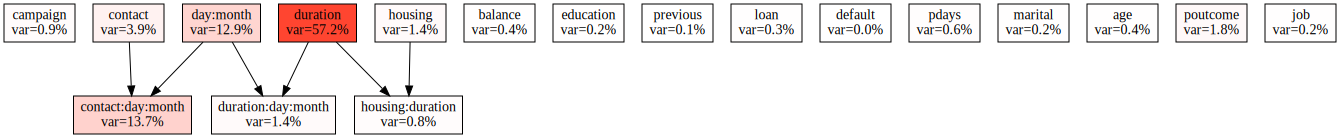

In [15]:
dot = decomposition_graph(grouped_decomposition, grouped_features.names())
dot

### FD-Trees

We now use FD-Trees to partition the input space into regions with reduced feature interactions. 
It is crucial to note that the `CoE_Tree` constructor must be given the **original** feature object (without groups), since FD-Trees are going to splits the input space along individual features and not groups of features. Nonetheless, the `.fit` methods must be given the `grouped_decomposition` that results from grouping features.
This is because we want the interactions involving `day` and `month` to already be minimized so that
FD-Trees can focus on remaining interactions.

In [16]:
from pyfd.fd_trees import CoE_Tree
from pyfd.plots import plot_legend, COLORS

# Original features are passed to the constructor
tree = CoE_Tree(max_depth=1, features=features, alpha=0.01)
# Fit a FDTree by passing the `grouped_decomposition` as argument.
tree.fit(background, grouped_decomposition)
tree.print(verbose=True)

LoA 0.1545
Samples 2000
If contact ≤ 0.0000:
|   LoA 0.0031
|   Samples 577
|   Region 0
else:
|   LoA 0.0181
|   Samples 1423
|   Region 1
Final LoA 0.0212


The FD-Tree has determined it is optimal to separate instance with `contact=0` from `contact>0`. Doing so 
has reduced the CoE (here called LoA) from 15.5% to 2.1%. But what does that split represent? Remember 
that features have been ordinally encoded, which is why `contact` takes numerical values. The category 
associated with each of its numarical can be accessed from the `features` object.

In [18]:
# `contact` is the 14th feature
print(features.feature_objs[14].cats)

['?', 'telephone', 'cellular']


This is a list whose $i$th element is the category encoded when `contact=i`. Consequently, the FD-Tree separates intances with missing and non-missing entries
for the `contact` feature. The FD-Tree can now be used to assign each datum to its region and describe each region with an interpretable rule.

In [19]:
# Using regional backgrounds
regions = tree.predict(background)
print(regions[:10])
rules = tree.rules()
print(rules)

[1 1 1 1 0 1 1 0 1 0]
{0: 'contact=?', 1: 'contact ∈ [telephone,cellular]'}


Functional Decompositons and Shapley Values can be computed on each region separately. Remember to pass the `grouped_features` to the `PyFD` primitives since the regions were computed under the assumption that some 
features were grouped.

In [20]:
# Using regional datasets
regional_backgrounds = [[], []]
regional_decomposition = [[], []]
regional_shap = [[], []]
for r in range(2):
    regional_backgrounds[r] = background[regions==r]
    # Regional Decomposition
    regional_decomposition[r] = get_components_ebm(model, 
                                                    regional_backgrounds[r],
                                                    regional_backgrounds[r],
                                                    features=grouped_features,
                                                    anchored=True)
    # Shapley values
    regional_shap[r] = shap_from_decomposition(regional_decomposition[r])

Once these regional functional decompostions have been computed, they can be leveraged to report global feature important and local explanations of model predictions.

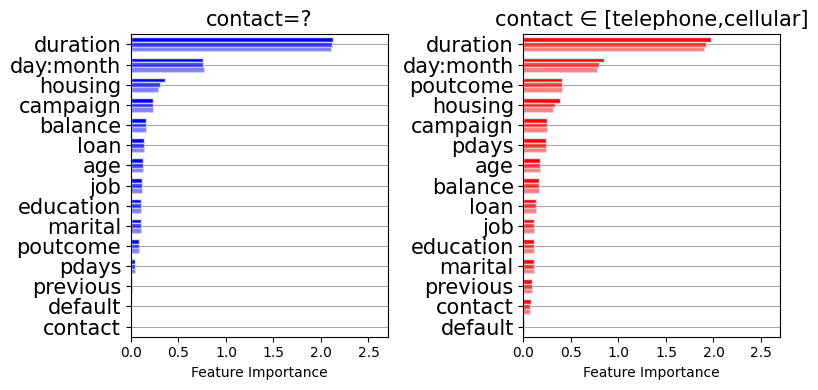

In [21]:
# One bar chart per region
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for r in range(2):
    I_PDP, I_PFI = get_PDP_PFI_importance(regional_decomposition[r]) 
    I_SHAP = get_SHAP_importance(regional_shap[r])
    bar([I_PFI, I_SHAP, I_PDP], grouped_features.names(), ax=axes[r], color=COLORS[r])
    axes[r].set_xlim(0, 2.7)
    axes[r].set_xlabel("Feature Importance")
    axes[r].set_title(rules[r], fontsize=15)

/home/gabriel/Desktop/POLY/PHD/Research/FunctionalDecomp/PyFD/pyfd/plots.py:438: UserWarning: Grouped Features Ignored
  warn("Grouped Features Ignored")


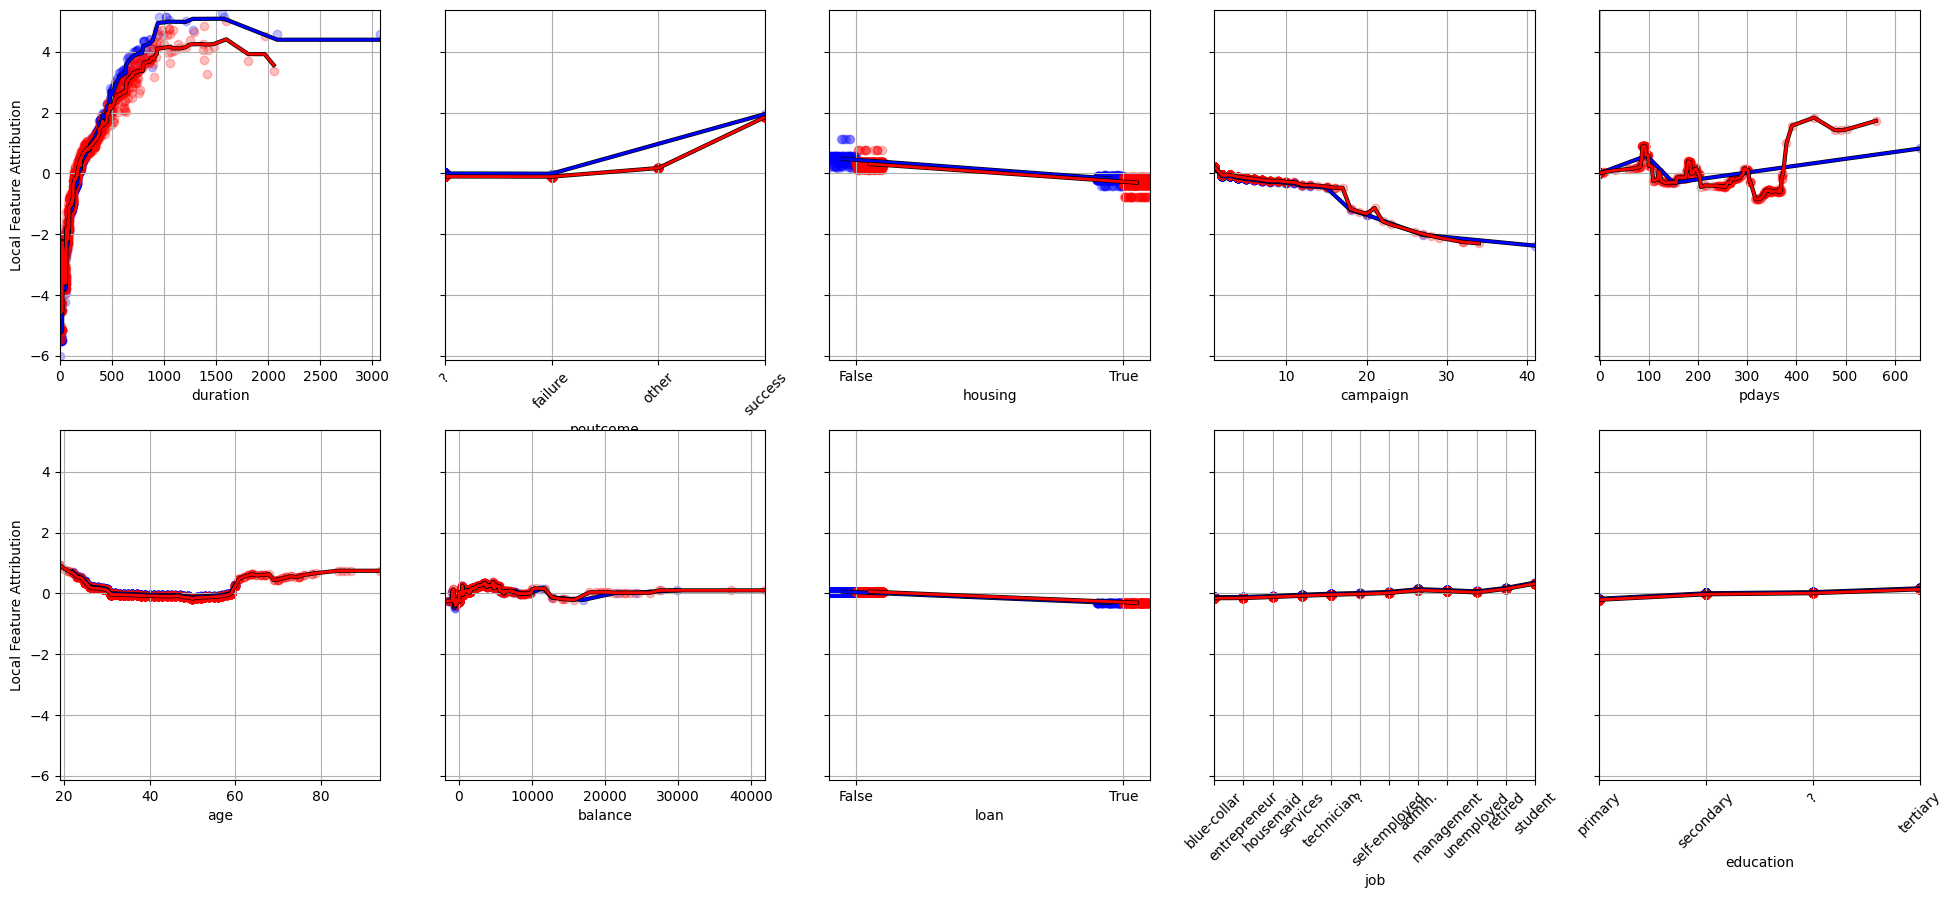

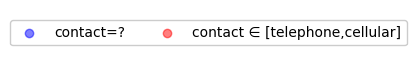

In [22]:
# Superposed scatter plots for both regions
attrib_scatter_plot(regional_decomposition, regional_shap, regional_backgrounds, grouped_features, idxs=10,
                    n_cols=5, normalize_y=True, figsize=(24, 10))
plot_legend(rules, ncol=2)

Our first observation is that, PDP/SHAP/PFI have a almost perfect agreement in the bar chart. Additionally, stronger agreement between the main effects (blue and red lines) 
and the Shapley Values (blue and red dots) are apparent in the scatter plot. Because the various explanability methods agree, we are confident that they provide a faithful
description of the model behavior. We now take the time to analyse these plots and highlight the model insights they provide.

First, the bar charts show that `duration` is the most important feature in both regions, demonstrating that
it is **the most important** for the EBM model. Looking at the scatter plot in both regions, there appears to be an increasing relationship between 
the call duration and the probability of success. This seems trivial in hindsight. Phone calls rejecting the offer would be short and sweet “No thanks, I am not 
interested (Hangs up)”. Successful phone calls would be longer since, upon acceptance, the bank would need to discuss logistic details
regarding the term deposit. Although the duration feature is highly predictive of the target variable, its causal relationship is backward: success $y$ is a cause of duration,
rendering the model inappropriate for planning future campaigns. For example, it is nonsensical to encourage longer phone calls to increase the probability of successes.

Second, according to the bar charts, the feature `campaign` is important in both regions and increasing it decreases the model output according to the scatter plots. 
Perhaps clients which were more frequently called became annoyed and were more prone to reject the bank proposition. Nevertheless, the model is non-causal and so be careful 
when recommending employees to call clients less frequently on future campaigns.

Third, in the bar charts, the feature `poutcome` (which measures the success of a previous campaign) is important on the red region, while it is not important in the blue region.
Looking at the scatter plots, in both regions there is a large positive attribution for `poutcome=success` implying that persons who previously made a deposit based 
on phone calls are more likely to do it again. But why is `pcoutcome` a lot less important in the blue region compared to the red one? It is not immediately clear by looking at the scatter plot, but a higher concentration blue points have `poutcome=?` compared to red ones. 

In [24]:
# Blue region
# Print the unique values and their count
print(np.unique(regional_backgrounds[0][:, 15], return_counts=True))
# Red Region
# Print the unique values and their count
print(np.unique(regional_backgrounds[1][:, 15], return_counts=True))

(array([0., 1., 3.]), array([574,   2,   1]))
(array([0., 1., 2., 3.]), array([1092,  181,   88,   62]))


This means that `poutcome` is more likely to be missing when `contact` is also missing. This statistical 
association explains why the importance of `poutcome` varies so much between regions.

We end this tutorial by investigating the effect that the grouped feature `day:month` has on the model 
output. This feature was not plotted by the `attrib_scatter_plot` function (`PyFD` actually send us a warning `warn("Grouped Features Ignored")`) because grouped features cannot be visualized using a 2d scatter plot.
To plot the joint effect of `day` and `month`, we propose computing a separate functional decomposition that focuses of these two features.
The resulting decomposition can be visualized as two heatmaps, one per region.

In [25]:
# We evaluate the functional decomposition on a 31x12 grid of all months and day
xx, yy = np.meshgrid(np.arange(1, 32), np.arange(12))
foreground = np.column_stack((xx.ravel(), yy.ravel()))

# Only select month and day and group them
subset_features = features.select([5, 6]).group([[0, 1]])

# Region 0
decomp = get_components_ebm(model, foreground, regional_backgrounds[0], subset_features, anchored=False)
zz_0 = decomp[(0,)].reshape(xx.shape)

# Region 1
decomp = get_components_ebm(model, foreground, regional_backgrounds[1], subset_features, anchored=False)
zz_1 = decomp[(0,)].reshape(xx.shape)
min_z = min(zz_0.min(), zz_1.min())
max_z = max(zz_0.max(), zz_1.max())

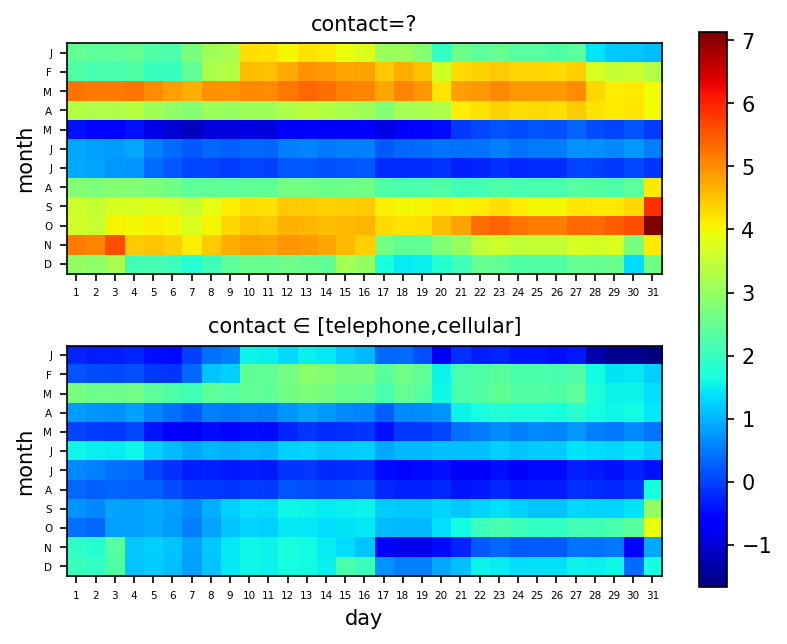

In [27]:
from matplotlib.colors import Normalize
from matplotlib import colormaps
import matplotlib.cm as cm

cmap = colormaps.get_cmap('jet')
normalizer = Normalize(min_z, max_z)

fig, axes = plt.subplots(2, 1, dpi=150)
axes[0].set_title(rules[0], fontsize=10)
axes[0].imshow(zz_0, cmap=cmap, norm=normalizer)
axes[0].set_ylabel("month")
axes[0].set_xticks(np.arange(31), labels=range(1, 32), fontsize=5)
axes[0].set_yticks(np.arange(12), labels=features.feature_objs[6].cats, fontsize=5)

axes[1].set_title(rules[1], fontsize=10)
axes[1].imshow(zz_1, cmap=cmap, norm=normalizer)
axes[1].set_xlabel("day")
axes[1].set_ylabel("month")
axes[1].set_xticks(np.arange(31), labels=range(1, 32), fontsize=5)
axes[1].set_yticks(np.arange(12), labels=features.feature_objs[6].cats, fontsize=5)

fig.colorbar(ax=axes.ravel().tolist(), mappable=cm.ScalarMappable(norm=normalizer, cmap=cmap))

These heatmap plots the amplitude of the function $h_i$ where $i$ is the `month:day` grouped feature. 
It is clear that the impact of `month:day` on model output depends strongly on whether `contact` is missing or not. When `contact=?`, the model output drops significantly during the summer. Such large 
drops on summer are not apparent when the feature contact is not missing. 

The fact that the effect of "date" on the model response depends strongly on whether `contact` is missing or 
not is enough to convince me that model should **not** be deployed. Indeed, there are many causes for missing features and they are often outside the control of the data scientist. We do not want something that is outside our control in deployment (here "missigness") to heavily impact models predictions.